In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyowm
import os
from datetime import datetime, date
import datetime as dt
import urllib
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import os 
import seaborn as sns #for styling the plots
import urllib.request
%matplotlib inline

In [172]:
sch_flight = pd.read_csv(r'FlightDelay/Data/Flight_Schedule.csv')
ops_flight = pd.read_csv(r'FlightDelay/Data/Aerobahn_with_Schedule.csv')
weather = pd.read_csv(r'FlightDelay/Data/weather_2021_2022.csv')
aircode = pd.read_csv(r'LookupTables/airport-codes.csv')

Merge Seasons data with flight schedule

In [173]:
#Create seasons
sch_flight['date'] = pd.to_datetime(sch_flight['Date'], format='%m/%d/%Y')
s = {12:'Winter',1:'Winter',2:'Winter',3:'Winter', 
     4:'Spring',5:'Spring',6:'Summer', 7:'Summer', 8:'Summer',
     9:'Summer',10:'Fall',11:'Fall'}

In [174]:
#Using lamdda to join season data with flight schedule
sch_flight['Season'] = sch_flight.filter(like='date').apply(lambda d: d.dt.month.map(s)).agg(', '.join, axis=1)

Merge Holiday data with flight schedule

In [175]:
#import US holidays (for NY and NJ) from the holidays library
hds = holidays.US(subdiv = 'NY',years = [2021,2022]) + holidays.US(subdiv = 'NJ',years = [2021,2022])

In [177]:
#days surrounding the holidays also tend to have higher demand. Identify the surrounding days.
fl_hds = []
for date, name in sorted(hds.items()):
    if (name == 'Christmas Day') | (name == 'Thanksgiving') | (name == "New Year's Day")| (name == 'Independence Day'):
    # for the big holidays, we would expect to see increased travel on 3 days before and after
        fl_hds.append(date - dt.timedelta(1))
        fl_hds.append(date - dt.timedelta(2))
        fl_hds.append(date - dt.timedelta(3))
        fl_hds.append(date + dt.timedelta(1))
        fl_hds.append(date + dt.timedelta(2))
        fl_hds.append(date + dt.timedelta(3))
    elif date.weekday() == 0:
    # for Monday holidays, we would expect to see increased travel on the Friday, Saturday, and Sunday prior
        fl_hds.append(date - dt.timedelta(1))
        fl_hds.append(date - dt.timedelta(2))
        fl_hds.append(date - dt.timedelta(3))
    elif date.weekday() == 4:
    # for Friday holidays, we would expect to see increased travel on the Saturday and Sunday after
        fl_hds.append(date + dt.timedelta(1))
        fl_hds.append(date + dt.timedelta(2))

In [178]:
sch_flight['holiday'] = 0
for i in sch_flight.index:
    if sch_flight.loc[i,'Date'] in hds:
        sch_flight.loc[i,'holiday'] = 1
    elif sch_flight.loc[i,'Date'] in fl_hds:
        sch_flight.loc[i,'holiday'] = 1

In [179]:
sch_flight['holiday'].describe()

count    54866.000000
mean         0.050632
std          0.219248
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: holiday, dtype: float64

Merge Region with flight schedule

In [180]:
#merge flight schedule data with region
sch_flight = pd.merge(sch_flight, aircode[['iata_code','Region']],left_on = 'Non-PA Airport Code',right_on = 'iata_code', how='left')

Prepping flight schedule and Operation data

In [181]:
#Selecting relevant columns
sch_flight = sch_flight [['Date', 'Military Time', 'Flight Direction',
       'PA Airport Code', 'Terminal Desc', 'Non-PA Airport Code',
       'Non-PA Airport Country Desc', 'International Domestic', 'State Desc',
       'Marketing Airline Desc', 'Marketing Airline ICAO Code',
       'Operating Airline Desc', 'Operating Airline ICAO Code',
       'Flight Number', 'General Aircraft Desc', 'Variant Aircraft Desc',
       'Variant Aircraft Code', 'Total Seats', 'Flight Distance',
       'Total Flights', 'iata_code', 'Region','Season','holiday']]

In [182]:
#Replace spaces in between column name
weather.columns = [x.replace(' ','_') for x in weather.columns]

In [183]:
print('Scheduled flight count:',sch_flight.shape , '& Operating Flight count:',ops_flight.shape)

Scheduled flight count: (55478, 24) & Operating Flight count: (53486, 23)


In [184]:
sch_flight= sch_flight.dropna()
ops_flight = ops_flight.dropna()

In [185]:
sch_flight.shape,ops_flight.shape

((55478, 24), (53193, 23))

In [186]:
ops_flight.columns

Index(['Date', 'Military Hour', 'Minutes', 'Military Time', 'Block Schedule',
       'Flight Direction', 'PA Airport Code', 'Terminal Desc',
       'Concourse Desc', 'Gate Desc', 'Non-PA Airport Code',
       'Non-PA Airport Country Desc', 'State Desc', 'Marketing Airline Desc',
       'Marketing Airline ICAO Code', 'Operating Airline Desc',
       'Operating Airline ICAO Code', 'Call Sign', 'General Aircraft Desc',
       'Variant Aircraft Desc', 'Variant Aircraft Code', 'Max Seats',
       'Total Flights'],
      dtype='object')

In [187]:
#Replace spaces in between column name
sch_flight.columns = [x.replace(' ','_') for x in sch_flight.columns]
ops_flight.columns = [x.replace(' ','_') for x in ops_flight.columns]

In [188]:
sch_flight['Date'] = pd.to_datetime(sch_flight['Date'])

In [189]:
sch_flight['DOW'] = sch_flight['Date'].dt.weekday

In [190]:
sch_flight.head(3)

,Date,Military_Time,Flight_Direction,PA_Airport_Code,Terminal_Desc,Non-PA_Airport_Code,Non-PA_Airport_Country_Desc,International_Domestic,State_Desc,Marketing_Airline_Desc,...,Variant_Aircraft_Desc,Variant_Aircraft_Code,Total_Seats,Flight_Distance,Total_Flights,iata_code,Region,Season,holiday,DOW
0,2021-01-01,0:59:00,Departure,EWR,EWR-Terminal B,SJU,USA,Domestic,Puerto Rico,Spirit Airlines,...,Airbus A321 (Sharklets),32B,228,"1,608",1,SJU,Latin America & Caribbean,Winter,1,4
1,2021-01-01,1:29:00,Arrival,EWR,EWR-Terminal B,STI,Dominican Republic,International,International,JetBlue Airways,...,Airbus A321,321,200,"1,476",1,STI,Latin America & Caribbean,Winter,1,4
2,2021-01-01,4:25:00,Arrival,EWR,EWR-Terminal B,DEL,India,International,International,United Airlines,...,Boeing 777-300ER,77W,350,"7,323",1,DEL,Asia,Winter,1,4


In [191]:
ops_flight['Flight_Departure'] = pd.to_datetime(ops_flight['Date']+' '+ops_flight['Military_Time'])

In [192]:
ops_flight.head(4)

,Date,Military_Hour,Minutes,Military_Time,Block_Schedule,Flight_Direction,PA_Airport_Code,Terminal_Desc,Concourse_Desc,Gate_Desc,...,Marketing_Airline_ICAO_Code,Operating_Airline_Desc,Operating_Airline_ICAO_Code,Call_Sign,General_Aircraft_Desc,Variant_Aircraft_Desc,Variant_Aircraft_Code,Max_Seats,Total_Flights,Flight_Departure
0,1/1/2021,0,22,0:22:45,1/1/2021 0:59,Arrival,EWR,EWR-Terminal B,Concourse B-1,B41B,...,NKS,Spirit Airlines,NKS,NKS1036,Airbus A318/319/320/321,Airbus A321,A321,185,1,2021-01-01 00:22:45
1,1/1/2021,1,5,1:05:58,1/1/2021 0:59,Departure,EWR,EWR-Terminal B,Concourse B-3,B61,...,NKS,Spirit Airlines,NKS,NKS1035,Airbus A318/319/320/321,Airbus A321,A321,185,1,2021-01-01 01:05:58
2,1/1/2021,1,47,1:47:14,1/1/2021 1:29,Arrival,EWR,EWR-Terminal B,Concourse B-2,B56,...,JBU,JetBlue Airways,JBU,JBU1494,Airbus A318/319/320/321,Airbus A321,A321,185,1,2021-01-01 01:47:14
3,1/1/2021,4,9,4:09:16,1/1/2021 4:45,Arrival,EWR,EWR-Terminal B,Concourse B-2,B53,...,UAL,United Airlines,UAL,UAL91,Boeing 787,Boeing 787-9,B789,280,1,2021-01-01 04:09:16


In [193]:
#Fitlering data for just departing flihts
sch_flight = sch_flight[sch_flight.Flight_Direction=='Departure']
ops_flight = ops_flight[ops_flight.Flight_Direction=='Departure']

In [194]:
sch_flight.shape,ops_flight.shape

((20325, 25), (18902, 24))

In [163]:
#sch_flight = sch_flight[(sch_flight['Date']>='9/1/2021') & (sch_flight['Date']<='9/30/2021')]
#ops_flight = ops_flight[(ops_flight['Date']>='9/1/2021') & (ops_flight['Date']<='9/30/2021')]

In [164]:
#(ops_flight['Date'].min(), ops_flight['Date'].max())

('9/1/2021', '9/30/2021')

In [195]:
sch_flight.shape,ops_flight.shape

((20325, 25), (18902, 24))

In [167]:
#ops_flight.to_csv('FlightDelay/Data/flight_Operation_Departure.csv')

In [196]:
#Sorting the data for proper alignment before merging.
sch_flight=sch_flight.sort_values(by=['Date','Operating_Airline_ICAO_Code'])
ops_flight=ops_flight.sort_values(by=['Date','Operating_Airline_ICAO_Code'])

In [197]:
sch_flight['Flight_Number'].dtype

dtype('int64')

In [198]:
type(ops_flight['Call_Sign'][1])

str

In [199]:
ops_flight ['Actual_Departure'] = ops_flight ['Military_Time']
sch_flight ['Actual_Scheduled'] = sch_flight ['Military_Time']

In [200]:
sch_flight.columns

Index(['Date', 'Military_Time', 'Flight_Direction', 'PA_Airport_Code',
       'Terminal_Desc', 'Non-PA_Airport_Code', 'Non-PA_Airport_Country_Desc',
       'International_Domestic', 'State_Desc', 'Marketing_Airline_Desc',
       'Marketing_Airline_ICAO_Code', 'Operating_Airline_Desc',
       'Operating_Airline_ICAO_Code', 'Flight_Number', 'General_Aircraft_Desc',
       'Variant_Aircraft_Desc', 'Variant_Aircraft_Code', 'Total_Seats',
       'Flight_Distance', 'Total_Flights', 'iata_code', 'Region', 'Season',
       'holiday', 'DOW', 'Actual_Scheduled'],
      dtype='object')

In [201]:
sch_flight = sch_flight[['Date','Actual_Scheduled','Non-PA_Airport_Country_Desc', 'International_Domestic',
                          'State_Desc','Region','Operating_Airline_Desc','Flight_Number','Operating_Airline_ICAO_Code','Total_Seats','holiday',
                         'DOW','Season']]

In [202]:
ops_flight = ops_flight[['Date','Actual_Departure','Military_Hour','Block_Schedule', 'Flight_Departure','Gate_Desc','Non-PA_Airport_Country_Desc', 'State_Desc',\
                         'Operating_Airline_Desc', 'Call_Sign','Operating_Airline_ICAO_Code']]

In [203]:
ops_flight.shape

(18902, 11)

In [204]:
sch_flight.shape

(20325, 13)

In [205]:
ops_flight['flight_Scheduled'] = pd.to_datetime(ops_flight['Block_Schedule']).dt.date

In [206]:
ops_flight['Scheduled_time'] = pd.to_datetime(ops_flight['Block_Schedule']).dt.time

In [207]:
ops_flight.head(3)

,Date,Actual_Departure,Military_Hour,Block_Schedule,Flight_Departure,Gate_Desc,Non-PA_Airport_Country_Desc,State_Desc,Operating_Airline_Desc,Call_Sign,Operating_Airline_ICAO_Code,flight_Scheduled,Scheduled_time
36,1/1/2021,11:50:31,11,1/1/2021 11:45,2021-01-01 11:50:31,B62,India,International,Air India Limited,AIC144,AIC,2021-01-01,11:45:00
86,1/1/2021,18:02:55,18,1/1/2021 17:55,2021-01-01 18:02:55,B61,Austria,International,Austrian Airlines,AUA90,AUA,2021-01-01,17:55:00
10,1/1/2021,6:35:16,6,1/1/2021 6:00,2021-01-01 06:35:16,B45,USA,Michigan,Delta Air Lines,DAL1646,DAL,2021-01-01,06:00:00


Merge weather data with Operation data

In [208]:
#Join Weather and flight operations data based on Date and Military hour.
ops_flight_weather = ops_flight.merge(weather, on = ['Date','Military_Hour'], how = 'left', indicator = True)

In [209]:
print(ops_flight.shape)
print(weather.shape)
print(ops_flight_weather.shape)

(18902, 13)
(11782, 6)
(19272, 18)


In [210]:
ops_flight_weather._merge.value_counts()

both          17387
left_only      1885
right_only        0
Name: _merge, dtype: int64

In [211]:
ops_flight_weather.isna().sum()

Date                              0
Actual_Departure                  0
Military_Hour                     0
Block_Schedule                    0
Flight_Departure                  0
Gate_Desc                         0
Non-PA_Airport_Country_Desc       0
State_Desc                        0
Operating_Airline_Desc            0
Call_Sign                         0
Operating_Airline_ICAO_Code       0
flight_Scheduled                  0
Scheduled_time                    0
Airport_Code                   1885
Weather_Description            1885
Precipitation_(Inches)         1885
Visibility_(Miles)             1885
_merge                            0
dtype: int64

In [212]:
ops_flight_weather = ops_flight_weather[ops_flight_weather._merge=='both']

In [213]:
ops_flight_weather.head(5)

,Date,Actual_Departure,Military_Hour,Block_Schedule,Flight_Departure,Gate_Desc,Non-PA_Airport_Country_Desc,State_Desc,Operating_Airline_Desc,Call_Sign,Operating_Airline_ICAO_Code,flight_Scheduled,Scheduled_time,Airport_Code,Weather_Description,Precipitation_(Inches),Visibility_(Miles),_merge
1015,10/1/2021,11:40:09,11,10/1/2021 10:45,2021-10-01 11:40:09,B66,USA,Tennessee,Allegiant Air,AAY2613,AAY,2021-10-01,10:45:00,EWR,Partly cloudy,0.0,10.0,both
1016,10/1/2021,6:17:01,6,10/1/2021 6:10,2021-10-01 06:17:01,B46A,USA,Michigan,Delta Air Lines,DAL1529,DAL,2021-10-01,06:10:00,EWR,Clear skies,0.0,10.0,both
1017,10/1/2021,6:37:42,6,10/1/2021 6:25,2021-10-01 06:37:42,B47,USA,Minnesota,Delta Air Lines,DAL1594,DAL,2021-10-01,06:25:00,EWR,Clear skies,0.0,10.0,both
1018,10/1/2021,7:18:36,7,10/1/2021 7:15,2021-10-01 07:18:36,B46B,USA,Georgia,Delta Air Lines,DAL2773,DAL,2021-10-01,07:15:00,EWR,Clear skies,0.0,10.0,both
1019,10/1/2021,10:43:09,10,10/1/2021 10:35,2021-10-01 10:43:09,B46A,USA,Georgia,Delta Air Lines,DAL2707,DAL,2021-10-01,10:35:00,EWR,Partly cloudy,0.0,10.0,both


In [214]:
ops_flight_weather.columns

Index(['Date', 'Actual_Departure', 'Military_Hour', 'Block_Schedule',
       'Flight_Departure', 'Gate_Desc', 'Non-PA_Airport_Country_Desc',
       'State_Desc', 'Operating_Airline_Desc', 'Call_Sign',
       'Operating_Airline_ICAO_Code', 'flight_Scheduled', 'Scheduled_time',
       'Airport_Code', 'Weather_Description', 'Precipitation_(Inches)',
       'Visibility_(Miles)', '_merge'],
      dtype='object')

In [215]:
ops_flight_weather = ops_flight_weather [['Date', 'Actual_Departure', 'Military_Hour', 'Block_Schedule',
       'Flight_Departure', 'Gate_Desc', 'Non-PA_Airport_Country_Desc',
       'State_Desc', 'Operating_Airline_Desc', 'Call_Sign',
       'Operating_Airline_ICAO_Code', 'flight_Scheduled', 'Scheduled_time',
       'Airport_Code', 'Weather_Description', 'Precipitation_(Inches)',
       'Visibility_(Miles)']]

In [216]:
sch_flight['Flight_Number'] = sch_flight['Flight_Number'].astype(int)
sch_flight['flight_Scheduled'] = pd.to_datetime(sch_flight['Date']).dt.date

In [217]:
#create a call sign field
sch_flight['Call_Sign'] = sch_flight['Operating_Airline_ICAO_Code']+''+sch_flight['Flight_Number'].astype(str)

In [218]:
sch_flight.head(3)

,Date,Actual_Scheduled,Non-PA_Airport_Country_Desc,International_Domestic,State_Desc,Region,Operating_Airline_Desc,Flight_Number,Operating_Airline_ICAO_Code,Total_Seats,holiday,DOW,Season,flight_Scheduled,Call_Sign
25,2021-01-01,11:45:00,India,International,International,Asia,Air India Limited,144,AIC,256,1,4,Winter,2021-01-01,AIC144
69,2021-01-01,17:55:00,Austria,International,International,Europe,Austrian Airlines,90,AUA,211,1,4,Winter,2021-01-01,AUA90
8,2021-01-01,6:00:00,USA,Domestic,Michigan,USA-Midwest,Delta Air Lines,1646,DAL,109,1,4,Winter,2021-01-01,DAL1646


Merge Operation and flight schedule data

In [219]:
flightmerge = sch_flight.merge(ops_flight_weather, on = ['flight_Scheduled','Call_Sign'], how = 'left', indicator = True)

In [220]:
print(ops_flight_weather.shape)
print(sch_flight.shape)
print(flightmerge.shape)

(17387, 17)
(20325, 15)
(20710, 31)


In [221]:
flightmerge._merge.value_counts()

both          16884
left_only      3826
right_only        0
Name: _merge, dtype: int64

In [222]:
flightmerge.isna().sum()

Date_x                              0
Actual_Scheduled                    0
Non-PA_Airport_Country_Desc_x       0
International_Domestic              0
State_Desc_x                        0
Region                              0
Operating_Airline_Desc_x            0
Flight_Number                       0
Operating_Airline_ICAO_Code_x       0
Total_Seats                         0
holiday                             0
DOW                                 0
Season                              0
flight_Scheduled                    0
Call_Sign                           0
Date_y                           3826
Actual_Departure                 3826
Military_Hour                    3826
Block_Schedule                   3826
Flight_Departure                 3826
Gate_Desc                        3826
Non-PA_Airport_Country_Desc_y    3826
State_Desc_y                     3826
Operating_Airline_Desc_y         3826
Operating_Airline_ICAO_Code_y    3826
Scheduled_time                   3826
Airport_Code

In [223]:
#merge data
flightmerge = flightmerge[flightmerge._merge=='both']

In [224]:
flightmerge.columns

Index(['Date_x', 'Actual_Scheduled', 'Non-PA_Airport_Country_Desc_x',
       'International_Domestic', 'State_Desc_x', 'Region',
       'Operating_Airline_Desc_x', 'Flight_Number',
       'Operating_Airline_ICAO_Code_x', 'Total_Seats', 'holiday', 'DOW',
       'Season', 'flight_Scheduled', 'Call_Sign', 'Date_y', 'Actual_Departure',
       'Military_Hour', 'Block_Schedule', 'Flight_Departure', 'Gate_Desc',
       'Non-PA_Airport_Country_Desc_y', 'State_Desc_y',
       'Operating_Airline_Desc_y', 'Operating_Airline_ICAO_Code_y',
       'Scheduled_time', 'Airport_Code', 'Weather_Description',
       'Precipitation_(Inches)', 'Visibility_(Miles)', '_merge'],
      dtype='object')

In [225]:
#Selecting relevant fields from clean data
flightmerge = flightmerge[['Date_x','Actual_Scheduled','Actual_Departure', 'Flight_Departure','Block_Schedule',
                         'Non-PA_Airport_Country_Desc_x',
                         'International_Domestic','Region','Operating_Airline_Desc_x',
                         'Operating_Airline_ICAO_Code_x','Total_Seats','Season','holiday', 'DOW',
                         'Military_Hour',
                         'Weather_Description','Precipitation_(Inches)', 'Visibility_(Miles)']]

In [226]:
flightmerge.shape

(16884, 18)

In [227]:
flightmerge.columns = [x.replace('_x','') for x in flightmerge.columns]

In [228]:
flightmerge.head(5)

,Date,Actual_Scheduled,Actual_Departure,Flight_Departure,Block_Schedule,Non-PA_Airport_Country_Desc,International_Domestic,Region,Operating_Airline_Desc,Operating_Airline_ICAO_Code,Total_Seats,Season,holiday,DOW,Military_Hour,Weather_Description,Precipitation_(Inches),Visibility_(Miles)
2040,2021-03-01,9:55:00,9:56:33,2021-03-01 09:56:33,3/1/2021 9:55,USA,Domestic,USA-Southeast,Allegiant Air,AAY,156,Winter,0,0,9.0,Overcast skies,0.0,2.5
2042,2021-03-01,11:15:00,11:42:35,2021-03-01 11:42:35,3/1/2021 11:15,India,International,Asia,Air India Limited,AIC,342,Winter,0,0,11.0,Raining,0.0,10.0
2043,2021-03-01,6:15:00,6:18:41,2021-03-01 06:18:41,3/1/2021 6:15,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,160,Winter,0,0,6.0,Raining,0.0,6.0
2044,2021-03-01,7:30:00,7:39:50,2021-03-01 07:39:50,3/1/2021 7:30,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,160,Winter,0,0,7.0,Raining,0.0,2.5
2045,2021-03-01,8:40:00,8:47:15,2021-03-01 08:47:15,3/1/2021 8:40,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,160,Winter,0,0,8.0,Overcast skies,0.0,2.5


In [229]:
flightmerge.isna().sum()

Date                           0
Actual_Scheduled               0
Actual_Departure               0
Flight_Departure               0
Block_Schedule                 0
Non-PA_Airport_Country_Desc    0
International_Domestic         0
Region                         0
Operating_Airline_Desc         0
Operating_Airline_ICAO_Code    0
Total_Seats                    0
Season                         0
holiday                        0
DOW                            0
Military_Hour                  0
Weather_Description            0
Precipitation_(Inches)         0
Visibility_(Miles)             0
dtype: int64

In [230]:
flightmerge['Flight_Schedule']=flightmerge['Block_Schedule']

In [231]:
flightmerge['Flight_Schedule']=pd.to_datetime(flightmerge['Flight_Schedule'])

In [232]:
#Calculating flight delays
flightmerge['Flight_Delay'] = flightmerge['Flight_Departure'] - flightmerge['Flight_Schedule']

In [233]:
flightmerge.head(3)

,Date,Actual_Scheduled,Actual_Departure,Flight_Departure,Block_Schedule,Non-PA_Airport_Country_Desc,International_Domestic,Region,Operating_Airline_Desc,Operating_Airline_ICAO_Code,Total_Seats,Season,holiday,DOW,Military_Hour,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Flight_Schedule,Flight_Delay
2040,2021-03-01,9:55:00,9:56:33,2021-03-01 09:56:33,3/1/2021 9:55,USA,Domestic,USA-Southeast,Allegiant Air,AAY,156,Winter,0,0,9.0,Overcast skies,0.0,2.5,2021-03-01 09:55:00,0 days 00:01:33
2042,2021-03-01,11:15:00,11:42:35,2021-03-01 11:42:35,3/1/2021 11:15,India,International,Asia,Air India Limited,AIC,342,Winter,0,0,11.0,Raining,0.0,10.0,2021-03-01 11:15:00,0 days 00:27:35
2043,2021-03-01,6:15:00,6:18:41,2021-03-01 06:18:41,3/1/2021 6:15,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,160,Winter,0,0,6.0,Raining,0.0,6.0,2021-03-01 06:15:00,0 days 00:03:41


In [235]:
flightMergeData = flightmerge

# Clean and Analyze Final Merge Dataset

In [240]:
flightmerge['Flight_Delay'].min(), flightmerge['Flight_Delay'].max()

(Timedelta('-1 days +14:52:16'), Timedelta('1 days 01:25:15'))

In [241]:
#Removing delays that goes into the negative values
flightmerge = flightmerge.loc[flightmerge['Flight_Delay']>='00:00:00']

In [242]:
flightmerge.shape

(16576, 20)

In [243]:
flightmerge['Flight_Delay'].min(), flightmerge['Flight_Delay'].max()

(Timedelta('0 days 00:00:00'), Timedelta('1 days 01:25:15'))

In [244]:
#Converting flight delay into seconds and divide by 3600 seconds to get hourly delay (60 minutes)
lst = []
for s in flightmerge['Flight_Delay']:
    lst.append(s.total_seconds()/3600)

In [245]:
flightmerge['Hour_Delay'] = lst

In [246]:
#Simple descriptive analysis to see columns relevance

flightmerge.describe()

,Total_Seats,holiday,DOW,Military_Hour,Precipitation_(Inches),Visibility_(Miles),Flight_Delay,Hour_Delay
count,16576.000000,16576.000000,16576.000000,16576.000000,16576.000000,16576.000000,16576,16576.000000
mean,183.933398,0.047961,3.026605,13.111969,0.006932,39.721248,0 days 00:31:48.573902027,0.530159
std,66.525500,0.213690,2.008478,5.556132,0.070505,1736.388952,0 days 00:55:35.647395031,0.926569
min,69.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0 days 00:00:00,0.000000
25%,162.000000,0.000000,1.000000,9.000000,0.000000,10.000000,0 days 00:09:18,0.155000
50%,182.000000,0.000000,3.000000,13.000000,0.000000,10.000000,0 days 00:16:15,0.270833
75%,228.000000,0.000000,5.000000,18.000000,0.000000,10.000000,0 days 00:32:51,0.547500
max,411.000000,1.000000,6.000000,23.000000,2.500000,99999.000000,1 days 01:25:15,25.420833


In [247]:
#converting hourly delay in minutes
flightmerge['DelayMinute'] = flightmerge['Hour_Delay']*60

In [248]:
flightmerge.head(3)

,Date,Actual_Scheduled,Actual_Departure,Flight_Departure,Block_Schedule,Non-PA_Airport_Country_Desc,International_Domestic,Region,Operating_Airline_Desc,Operating_Airline_ICAO_Code,...,holiday,DOW,Military_Hour,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Flight_Schedule,Flight_Delay,Hour_Delay,DelayMinute
2040,2021-03-01,9:55:00,9:56:33,2021-03-01 09:56:33,3/1/2021 9:55,USA,Domestic,USA-Southeast,Allegiant Air,AAY,...,0,0,9.0,Overcast skies,0.0,2.5,2021-03-01 09:55:00,0 days 00:01:33,0.025833,1.550000
2042,2021-03-01,11:15:00,11:42:35,2021-03-01 11:42:35,3/1/2021 11:15,India,International,Asia,Air India Limited,AIC,...,0,0,11.0,Raining,0.0,10.0,2021-03-01 11:15:00,0 days 00:27:35,0.459722,27.583333
2043,2021-03-01,6:15:00,6:18:41,2021-03-01 06:18:41,3/1/2021 6:15,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,...,0,0,6.0,Raining,0.0,6.0,2021-03-01 06:15:00,0 days 00:03:41,0.061389,3.683333


In [249]:
#Extract only flight delay greater than or equal to 15 minutes; which seems to have the most impact 
flightmerge = flightmerge.loc[flightmerge['DelayMinute']>=15]

In [250]:
flightmerge['DelayInMinute'] = flightmerge['DelayMinute']

In [251]:
flightmerge.shape

(8845, 23)

In [252]:
flightmerge['counter'] = 1

In [253]:
flightMergeData = flightmerge

In [236]:
#topDelayAirlines=flightmerge.groupby(['Operating_Airline_Desc']).agg({'counter':'sum'})

In [222]:
#topDelayAirlines.counter.sum()

12471

In [223]:
#Top 10 airlines with the most delay for 2021 data
#topDelayAirlines = topDelayAirlines.sort_values(by=['counter'],ascending=False).head(10)

In [224]:
#topDelayAirlines.to_csv('top10DelayAirlineV10.csv')

In [85]:
flightmerge['Hour'] = pd.to_datetime(flightmerge['Flight_Schedule']).dt.hour

In [86]:
flightmerge.head(3)

,Date,Actual_Scheduled,Actual_Departure,Flight_Departure,Block_Schedule,Non-PA_Airport_Country_Desc,International_Domestic,Region,Operating_Airline_Desc,Operating_Airline_ICAO_Code,...,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Flight_Schedule,Flight_Delay,Hour_Delay,DelayMinute,DelayInMinute,counter,Hour
2042,2021-03-01,11:15:00,11:42:35,2021-03-01 11:42:35,3/1/2021 11:15,India,International,Asia,Air India Limited,AIC,...,Raining,0.0,10.0,2021-03-01 11:15:00,0 days 00:27:35,0.459722,27.583333,27.583333,1,11
2051,2021-03-01,18:45:00,19:30:54,2021-03-01 19:30:54,3/1/2021 18:45,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,...,Partly cloudy,0.0,10.0,2021-03-01 18:45:00,0 days 00:45:54,0.765000,45.900000,45.900000,1,18
2053,2021-03-01,18:10:00,18:29:37,2021-03-01 18:29:37,3/1/2021 18:10,Germany,International,Europe,Lufthansa,DLH,...,Partly cloudy,0.0,10.0,2021-03-01 18:10:00,0 days 00:19:37,0.326944,19.616667,19.616667,1,18


In [87]:
flightmerge.Hour_Delay.isna().sum()

0

In [88]:
flightmerge.Hour_Delay.min(), flightmerge.Hour_Delay.max()

(0.25, 25.420833333333334)

In [89]:
flightmerge['Hour'].unique()

array([11, 18, 13,  6,  8, 16,  7, 15,  9, 12, 21, 10, 17, 22,  1, 19, 20,
       14, 23,  5,  0], dtype=int64)

In [90]:
#Creating time categories
morning = [6,7,8,9,10,11]
afternoon = [12,13,14,15,16,17]
evening = [18,19,20,21]
overnight = [22,23,0,1,2,3,4,5]

In [91]:
lsthour = []
for s in flightmerge['Hour']:
        if s in morning:
            lsthour.append('Morning')
        elif s in afternoon:
            lsthour.append('Afternoon')
        elif s in evening:
            lsthour.append('Evening')
        elif s in overnight:
            lsthour.append('Overnight')

In [92]:
flightmerge ['Time Category'] = lsthour

In [93]:
flightmerge.head(4)

,Date,Actual_Scheduled,Actual_Departure,Flight_Departure,Block_Schedule,Non-PA_Airport_Country_Desc,International_Domestic,Region,Operating_Airline_Desc,Operating_Airline_ICAO_Code,...,Precipitation_(Inches),Visibility_(Miles),Flight_Schedule,Flight_Delay,Hour_Delay,DelayMinute,DelayInMinute,counter,Hour,Time Category
2042,2021-03-01,11:15:00,11:42:35,2021-03-01 11:42:35,3/1/2021 11:15,India,International,Asia,Air India Limited,AIC,...,0.0,10.0,2021-03-01 11:15:00,0 days 00:27:35,0.459722,27.583333,27.583333,1,11,Morning
2051,2021-03-01,18:45:00,19:30:54,2021-03-01 19:30:54,3/1/2021 18:45,USA,Domestic,USA-Southeast,Delta Air Lines,DAL,...,0.0,10.0,2021-03-01 18:45:00,0 days 00:45:54,0.765000,45.900000,45.900000,1,18,Evening
2053,2021-03-01,18:10:00,18:29:37,2021-03-01 18:29:37,3/1/2021 18:10,Germany,International,Europe,Lufthansa,DLH,...,0.0,10.0,2021-03-01 18:10:00,0 days 00:19:37,0.326944,19.616667,19.616667,1,18,Evening
2060,2021-03-01,13:29:00,13:48:52,2021-03-01 13:48:52,3/1/2021 13:29,USA,Domestic,USA-Southeast,Frontier Airlines,FFT,...,0.0,10.0,2021-03-01 13:29:00,0 days 00:19:52,0.331111,19.866667,19.866667,1,13,Afternoon


In [94]:
#Selecting relevant fields from clean data
flightmerge = flightmerge[['Date','Flight_Schedule','Flight_Departure','International_Domestic','Region',
                           'Non-PA_Airport_Country_Desc','Operating_Airline_Desc','Total_Seats','Season','holiday',
                           'DOW','Weather_Description','Precipitation_(Inches)', 
                           'Visibility_(Miles)','Hour_Delay', 'Time Category']]

In [95]:
flightmerge.head()

,Date,Flight_Schedule,Flight_Departure,International_Domestic,Region,Non-PA_Airport_Country_Desc,Operating_Airline_Desc,Total_Seats,Season,holiday,DOW,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Hour_Delay,Time Category
2042,2021-03-01,2021-03-01 11:15:00,2021-03-01 11:42:35,International,Asia,India,Air India Limited,342,Winter,0,0,Raining,0.0,10.0,0.459722,Morning
2051,2021-03-01,2021-03-01 18:45:00,2021-03-01 19:30:54,Domestic,USA-Southeast,USA,Delta Air Lines,110,Winter,0,0,Partly cloudy,0.0,10.0,0.765000,Evening
2053,2021-03-01,2021-03-01 18:10:00,2021-03-01 18:29:37,International,Europe,Germany,Lufthansa,255,Winter,0,0,Partly cloudy,0.0,10.0,0.326944,Evening
2060,2021-03-01,2021-03-01 13:29:00,2021-03-01 13:48:52,Domestic,USA-Southeast,USA,Frontier Airlines,186,Winter,0,0,Overcast skies,0.0,10.0,0.331111,Afternoon
2074,2021-03-02,2021-03-02 11:15:00,2021-03-02 11:47:16,International,Asia,India,Air India Limited,342,Winter,0,1,Partly cloudy,0.0,10.0,0.537778,Morning


In [96]:
flightmerge['Weather_Description'].unique
#Clear skies, Partly cloudy,Raining

<bound method Series.unique of 2042            Raining
2051      Partly cloudy
2053      Partly cloudy
2060     Overcast skies
2074      Partly cloudy
              ...      
20688     Partly cloudy
20691    Overcast skies
20693    Overcast skies
20702     Partly cloudy
20703    Overcast skies
Name: Weather_Description, Length: 8845, dtype: object>

In [97]:
flightmerge = flightmerge[flightmerge.Weather_Description !='Clear skies']

In [98]:
flightmerge.head()

,Date,Flight_Schedule,Flight_Departure,International_Domestic,Region,Non-PA_Airport_Country_Desc,Operating_Airline_Desc,Total_Seats,Season,holiday,DOW,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Hour_Delay,Time Category
2042,2021-03-01,2021-03-01 11:15:00,2021-03-01 11:42:35,International,Asia,India,Air India Limited,342,Winter,0,0,Raining,0.0,10.0,0.459722,Morning
2051,2021-03-01,2021-03-01 18:45:00,2021-03-01 19:30:54,Domestic,USA-Southeast,USA,Delta Air Lines,110,Winter,0,0,Partly cloudy,0.0,10.0,0.765000,Evening
2053,2021-03-01,2021-03-01 18:10:00,2021-03-01 18:29:37,International,Europe,Germany,Lufthansa,255,Winter,0,0,Partly cloudy,0.0,10.0,0.326944,Evening
2060,2021-03-01,2021-03-01 13:29:00,2021-03-01 13:48:52,Domestic,USA-Southeast,USA,Frontier Airlines,186,Winter,0,0,Overcast skies,0.0,10.0,0.331111,Afternoon
2074,2021-03-02,2021-03-02 11:15:00,2021-03-02 11:47:16,International,Asia,India,Air India Limited,342,Winter,0,1,Partly cloudy,0.0,10.0,0.537778,Morning


In [99]:
flightmerge['Time'] = pd.to_datetime(flightmerge['Flight_Departure']).dt.time
flightmerge['Month'] = pd.to_datetime(flightmerge['Flight_Departure']).dt.month
flightmerge['Day'] = pd.to_datetime(flightmerge['Flight_Departure']).dt.day
flightmerge['Year'] = pd.to_datetime(flightmerge['Flight_Departure']).dt.year

In [100]:
flightmerge.head()

,Date,Flight_Schedule,Flight_Departure,International_Domestic,Region,Non-PA_Airport_Country_Desc,Operating_Airline_Desc,Total_Seats,Season,holiday,DOW,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Hour_Delay,Time Category,Time,Month,Day,Year
2042,2021-03-01,2021-03-01 11:15:00,2021-03-01 11:42:35,International,Asia,India,Air India Limited,342,Winter,0,0,Raining,0.0,10.0,0.459722,Morning,11:42:35,3,1,2021
2051,2021-03-01,2021-03-01 18:45:00,2021-03-01 19:30:54,Domestic,USA-Southeast,USA,Delta Air Lines,110,Winter,0,0,Partly cloudy,0.0,10.0,0.765000,Evening,19:30:54,3,1,2021
2053,2021-03-01,2021-03-01 18:10:00,2021-03-01 18:29:37,International,Europe,Germany,Lufthansa,255,Winter,0,0,Partly cloudy,0.0,10.0,0.326944,Evening,18:29:37,3,1,2021
2060,2021-03-01,2021-03-01 13:29:00,2021-03-01 13:48:52,Domestic,USA-Southeast,USA,Frontier Airlines,186,Winter,0,0,Overcast skies,0.0,10.0,0.331111,Afternoon,13:48:52,3,1,2021
2074,2021-03-02,2021-03-02 11:15:00,2021-03-02 11:47:16,International,Asia,India,Air India Limited,342,Winter,0,1,Partly cloudy,0.0,10.0,0.537778,Morning,11:47:16,3,2,2021


In [101]:
flightmerge = flightmerge[['Month', 'Day', 'Year','International_Domestic','Region',
                           'Operating_Airline_Desc','Total_Seats','Hour_Delay','Season', 
                            'holiday', 'DOW', 'Weather_Description',
                            'Precipitation_(Inches)', 'Visibility_(Miles)',
                            'Time Category']]

In [237]:
flightmerge.Operating_Airline_Desc.unique()

array(['Allegiant Air', 'Air India Limited', 'Delta Air Lines',
       'Lufthansa', 'Endeavor Airlines', 'Frontier Airlines',
       'Spirit Airlines', 'Republic Airways',
       'Scandinavian Airlines System', 'Austrian Airlines',
       'Ethiopian Airlines', 'SkyWest', 'Swiss International Airlines',
       'TAP Portugal', 'El Al Israel Airlines', 'LOT Polish Airlines',
       'Sun Country Airlines', 'Emirates', 'La Compagnie', 'Icelandair',
       'Porter Airlines', 'JetBlue Airways', 'French Bee',
       'British Airways', 'Aer Lingus'], dtype=object)

In [103]:
flightmerge.head()

,Month,Day,Year,International_Domestic,Region,Operating_Airline_Desc,Total_Seats,Hour_Delay,Season,holiday,DOW,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Time Category
2042,3,1,2021,International,Asia,Air India Limited,342,0.459722,Winter,0,0,Raining,0.0,10.0,Morning
2051,3,1,2021,Domestic,USA-Southeast,Delta Air Lines,110,0.765000,Winter,0,0,Partly cloudy,0.0,10.0,Evening
2053,3,1,2021,International,Europe,Lufthansa,255,0.326944,Winter,0,0,Partly cloudy,0.0,10.0,Evening
2060,3,1,2021,Domestic,USA-Southeast,Frontier Airlines,186,0.331111,Winter,0,0,Overcast skies,0.0,10.0,Afternoon
2074,3,2,2021,International,Asia,Air India Limited,342,0.537778,Winter,0,1,Partly cloudy,0.0,10.0,Morning


# Prep Data for Predictions

In [104]:
flightmerge['Destination'] = flightmerge['International_Domestic'].replace({'Domestic':0,'International':1})
flightmerge = pd.get_dummies(flightmerge,columns = ['Region','Operating_Airline_Desc','Time Category','DOW','Weather_Description',\
                                           'Season'])

Train: march 2021 - september 2021
Validation (walk forward validation): october 2021 - november 2021
Test: December 2021


In [105]:
train = flightmerge[flightmerge['Month'] < 10]
val = flightmerge[(flightmerge['Month']  >=10) | (flightmerge['Month'] <=11)]
test = flightmerge[flightmerge['Month'] == 12]

In [106]:
#fit the StandardScaler on the training data, transform all data
ss = StandardScaler()
ss.fit(train[['Total_Seats']])
train[['Total_Seats_sc']] = ss.transform(train[['Total_Seats']])
val[['Total_Seats_sc']] = ss.transform(val[['Total_Seats']])
test[['Total_Seats_sc']] = ss.transform(test[['Total_Seats']])

In [107]:
train = train.drop(['Month', 'Day', 'Year','International_Domestic'],axis=1)
val = val.drop(['Month', 'Day', 'Year','International_Domestic'],axis=1)
test = test.drop(['Month', 'Day', 'Year','International_Domestic'],axis=1)

In [108]:
X_train = train.drop(['Hour_Delay','Total_Seats'],axis=1)
y_train = train['Hour_Delay']

In [109]:
X_val = val.drop(['Hour_Delay','Total_Seats'],axis=1)
y_val = val['Hour_Delay']

In [110]:
X_test = test.drop(['Hour_Delay','Total_Seats'],axis=1)
y_test = test['Hour_Delay']

In [111]:
train.columns

Index(['Total_Seats', 'Hour_Delay', 'holiday', 'Precipitation_(Inches)',
       'Visibility_(Miles)', 'Destination', 'Region_Africa', 'Region_Asia',
       'Region_Canada', 'Region_Europe', 'Region_Latin America & Caribbean',
       'Region_USA-Midwest', 'Region_USA-Northeast', 'Region_USA-Pacific West',
       'Region_USA-Plains', 'Region_USA-Southeast',
       'Operating_Airline_Desc_Aer Lingus',
       'Operating_Airline_Desc_Air India Limited',
       'Operating_Airline_Desc_Allegiant Air',
       'Operating_Airline_Desc_Austrian Airlines',
       'Operating_Airline_Desc_British Airways',
       'Operating_Airline_Desc_Delta Air Lines',
       'Operating_Airline_Desc_El Al Israel Airlines',
       'Operating_Airline_Desc_Emirates',
       'Operating_Airline_Desc_Endeavor Airlines',
       'Operating_Airline_Desc_Ethiopian Airlines',
       'Operating_Airline_Desc_French Bee',
       'Operating_Airline_Desc_Frontier Airlines',
       'Operating_Airline_Desc_Icelandair',
       'Oper

In [122]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [112]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'In-sample R2: {lm.score(X_train, y_train)}')
print(f'Validation R2: {lm.score(X_val, y_val)}')

In-sample R2: 0.047519584179018026
Validation R2: 0.003935740128567677


In [113]:
import statsmodels.api as sm
lm = sm.OLS(y_train,X_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             Hour_Delay   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     5.437
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           5.62e-29
Time:                        11:14:12   Log-Likelihood:                -8304.9
No. Observations:                5060   AIC:                         1.670e+04
Df Residuals:                    5013   BIC:                         1.701e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [114]:
clf = Ridge(alpha=1)
clf.fit(X_train,y_train)
print(f"Test Ridge score, alpha value 1:", clf.score(X_test, y_test))

Test Ridge score, alpha value 1: -0.2316465355825139


In [118]:
#Remove some extended variables
X_trainExt = train.drop(['Total_Seats', 'Hour_Delay', 'holiday',
       'Visibility_(Miles)', 'Region_Africa', 'Region_Asia',
       'Region_Canada', 'Region_Europe', 'Region_Latin America & Caribbean',
       'Region_USA-Midwest', 'Region_USA-Northeast', 'Region_USA-Pacific West',
       'Region_USA-Plains', 'Region_USA-Southeast',
       'Time Category_Afternoon',
       'Time Category_Evening', 'Time Category_Morning',
       'Time Category_Overnight','Weather_Description_Overcast skies',
       'Weather_Description_Partly cloudy', 'Weather_Description_Raining',
       'Weather_Description_Showers', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Season_Winter','Total_Seats_sc',
       'Weather_Description_Thunderstorms'],axis=1)

X_valExt = val.drop(['Total_Seats', 'Hour_Delay', 'holiday',
       'Visibility_(Miles)', 'Region_Africa', 'Region_Asia',
       'Region_Canada', 'Region_Europe', 'Region_Latin America & Caribbean',
       'Region_USA-Midwest', 'Region_USA-Northeast', 'Region_USA-Pacific West',
       'Region_USA-Plains', 'Region_USA-Southeast',
       'Time Category_Afternoon',
       'Time Category_Evening', 'Time Category_Morning',
       'Time Category_Overnight','Weather_Description_Overcast skies',
       'Weather_Description_Partly cloudy', 'Weather_Description_Raining',
       'Weather_Description_Showers', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Season_Winter','Total_Seats_sc',
       'Weather_Description_Thunderstorms'],axis=1)

X_testExt = test.drop(['Total_Seats', 'Hour_Delay', 'holiday',
       'Visibility_(Miles)', 'Region_Africa', 'Region_Asia',
       'Region_Canada', 'Region_Europe', 'Region_Latin America & Caribbean',
       'Region_USA-Midwest', 'Region_USA-Northeast', 'Region_USA-Pacific West',
       'Region_USA-Plains', 'Region_USA-Southeast',
       'Time Category_Afternoon',
       'Time Category_Evening', 'Time Category_Morning',
       'Time Category_Overnight','Weather_Description_Overcast skies',
       'Weather_Description_Partly cloudy', 'Weather_Description_Raining',
       'Weather_Description_Showers', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Season_Winter','Total_Seats_sc',
       'Weather_Description_Thunderstorms'],axis=1)

In [119]:
X_trainExt.head()

,Precipitation_(Inches),Destination,Operating_Airline_Desc_Aer Lingus,Operating_Airline_Desc_Air India Limited,Operating_Airline_Desc_Allegiant Air,Operating_Airline_Desc_Austrian Airlines,Operating_Airline_Desc_British Airways,Operating_Airline_Desc_Delta Air Lines,Operating_Airline_Desc_El Al Israel Airlines,Operating_Airline_Desc_Emirates,...,Operating_Airline_Desc_Swiss International Airlines,Operating_Airline_Desc_TAP Portugal,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Weather_Description_Snowing
2042,0.0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2051,0.0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2053,0.0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2060,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2074,0.0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [123]:
rf = RandomForestRegressor(max_depth=30, n_estimators = 1000)
rf.fit(X_trainExt,y_train)
print(f"Validation RF score:", rf.score(X_valExt, y_val))

Validation RF score: 0.029600488063653563


In [124]:
fi_rf=pd.DataFrame([list(X_trainExt.columns),list(rf.feature_importances_)]).T
fi_rf.columns = ['variable','feature_importance']
fi_rf = fi_rf.sort_values('feature_importance',ascending=False)
fi_rf

,variable,feature_importance
0,Precipitation_(Inches),0.160101
32,DOW_5,0.134085
1,Destination,0.075607
30,DOW_3,0.074883
13,Operating_Airline_Desc_Frontier Airlines,0.061686
33,DOW_6,0.04832
7,Operating_Airline_Desc_Delta Air Lines,0.042045
31,DOW_4,0.041816
5,Operating_Airline_Desc_Austrian Airlines,0.04175
10,Operating_Airline_Desc_Endeavor Airlines,0.03776


Analysis the clean data using linear regression, laso,ridge, random forest

In [125]:
lm = LinearRegression()
lm.fit(X_trainExt, y_train)
print(f'In-sample R2: {lm.score(X_trainExt, y_train)}')
print(f'Validation R2: {lm.score(X_valExt, y_val)}')

In-sample R2: 0.02156553008848816
Validation R2: -7.211868276558887e+21


In [126]:
import statsmodels.api as sm
lm = sm.OLS(y_train,X_trainExt).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             Hour_Delay   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.829
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           2.21e-11
Time:                        11:20:59   Log-Likelihood:                -8372.9
No. Observations:                5060   AIC:                         1.681e+04
Df Residuals:                    5030   BIC:                         1.700e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [127]:
for a in np.logspace(-5,0,20):
    clf = Lasso(alpha=a)
    clf.fit(X_trainExt,y_train)
    print(f"Validation lasso score, alpha value {a}:", clf.score(X_valExt, y_val))

Validation lasso score, alpha value 1e-05: 0.004015890470139505
Validation lasso score, alpha value 1.8329807108324375e-05: 0.004119267859597375
Validation lasso score, alpha value 3.359818286283781e-05: 0.004306880989338846
Validation lasso score, alpha value 6.158482110660267e-05: 0.004656285800048399
Validation lasso score, alpha value 0.00011288378916846884: 0.0055527568733702015
Validation lasso score, alpha value 0.00020691380811147902: 0.007077809406443536
Validation lasso score, alpha value 0.000379269019073225: 0.008991339070675508
Validation lasso score, alpha value 0.0006951927961775605: 0.010715377492408584
Validation lasso score, alpha value 0.0012742749857031334: 0.01071869227864064
Validation lasso score, alpha value 0.002335721469090121: 0.009555879593910355
Validation lasso score, alpha value 0.004281332398719391: 0.007279041048349533
Validation lasso score, alpha value 0.007847599703514606: 0.006797352704719373
Validation lasso score, alpha value 0.01438449888287663: 

In [128]:
for a in np.logspace(-5,1,10):
    clf = Ridge(alpha=1)
    clf.fit(X_trainExt,y_train)
    print(f"Validation Ridge score, alpha value {a}:", clf.score(X_valExt, y_val))

Validation Ridge score, alpha value 1e-05: 0.006018023740209877
Validation Ridge score, alpha value 4.641588833612782e-05: 0.006018023740209877
Validation Ridge score, alpha value 0.00021544346900318823: 0.006018023740209877
Validation Ridge score, alpha value 0.001: 0.006018023740209877
Validation Ridge score, alpha value 0.004641588833612777: 0.006018023740209877
Validation Ridge score, alpha value 0.021544346900318822: 0.006018023740209877
Validation Ridge score, alpha value 0.1: 0.006018023740209877
Validation Ridge score, alpha value 0.46415888336127725: 0.006018023740209877
Validation Ridge score, alpha value 2.154434690031882: 0.006018023740209877
Validation Ridge score, alpha value 10.0: 0.006018023740209877


In [129]:
clf = Ridge(alpha=1)
clf.fit(X_trainExt,y_train)
print(f"Test Ridge score, alpha value 1:", clf.score(X_testExt, y_test))

Test Ridge score, alpha value 1: -0.06300138883404083


In [130]:
for d in range(5,20,5):
    rf = RandomForestRegressor(max_depth=d, n_estimators = 100)
    rf.fit(X_trainExt,y_train)
    print(f"Validation RF score, max_depth value {d}:", rf.score(X_valExt, y_val))

Validation RF score, max_depth value 5: 0.023202035662148512
Validation RF score, max_depth value 10: 0.031274674289057836
Validation RF score, max_depth value 15: 0.030507103771540978


In [131]:
fi_rf=pd.DataFrame([list(X_trainExt.columns),list(rf.feature_importances_)]).T
fi_rf.columns = ['variable','feature_importance']
fi_rf = fi_rf.sort_values('feature_importance',ascending=False)
fi_rf

,variable,feature_importance
0,Precipitation_(Inches),0.164243
32,DOW_5,0.145341
1,Destination,0.076477
30,DOW_3,0.074764
13,Operating_Airline_Desc_Frontier Airlines,0.060925
33,DOW_6,0.049389
31,DOW_4,0.040611
7,Operating_Airline_Desc_Delta Air Lines,0.039512
10,Operating_Airline_Desc_Endeavor Airlines,0.037778
22,Operating_Airline_Desc_SkyWest,0.033518


# Previous Analysis - Spring Semester

In [237]:
#weather api call
#owm = pyowm.OWM('2d8396b4a60bab7cdcc9b86d2313af78')

In [152]:
#manager = owm.weather_manager()

In [153]:
#observation = manager.weather_at_place('New Jersey, USA')

In [174]:
#temp =observation.weather.temperature('celsius')
#wind = observation.weather.wind()

In [ ]:
#print(temp)
#print(wind)

In [254]:
flightMergeData['Operating_Airline_Desc']

2042                Air India Limited
2051                  Delta Air Lines
2053                        Lufthansa
2060                Frontier Airlines
2074                Air India Limited
                     ...             
20688                 Spirit Airlines
20691                 Spirit Airlines
20693                 Spirit Airlines
20702    Scandinavian Airlines System
20703            Sun Country Airlines
Name: Operating_Airline_Desc, Length: 8845, dtype: object

In [255]:
Airline = flightMergeData[['Operating_Airline_Desc', 'Hour_Delay']].groupby(['Operating_Airline_Desc']).count()

In [256]:
#Top 10 airlines with the most delay for 2021 data
topDelayFlights = Airline.sort_values(by=['Hour_Delay'],ascending=False).head(10)

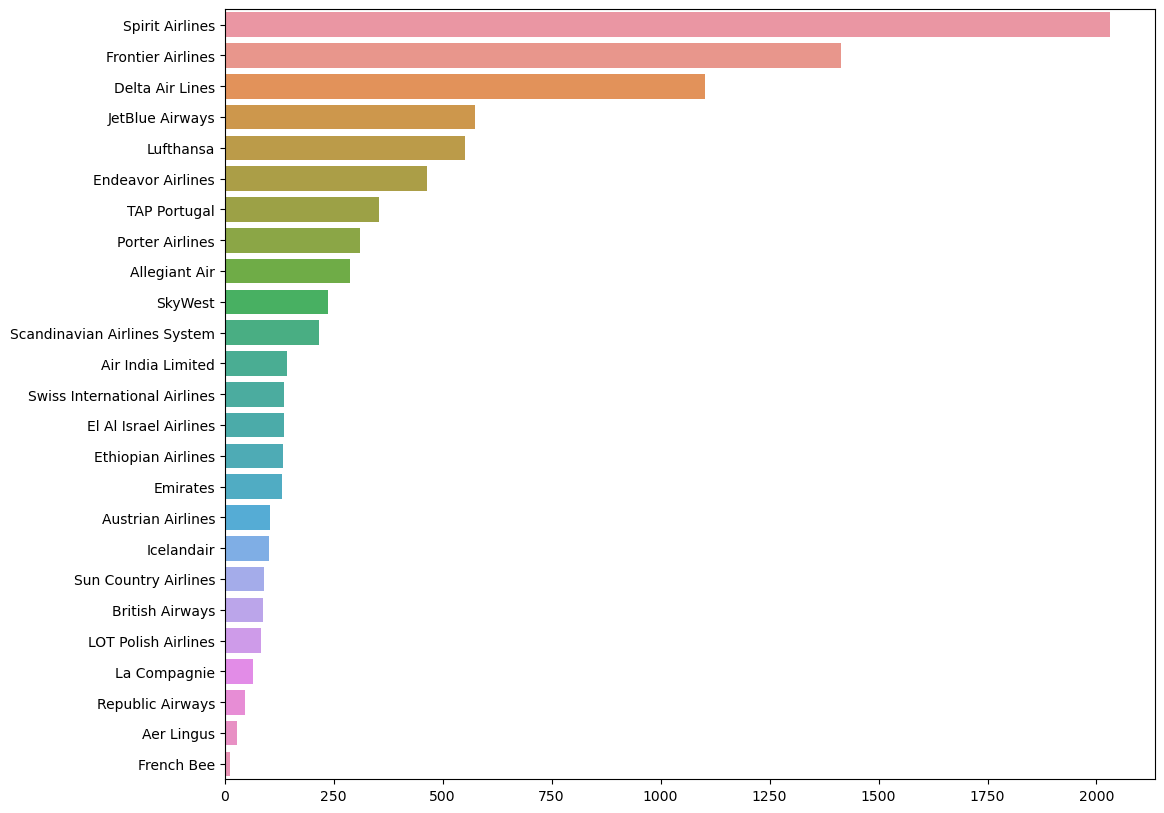

In [257]:
#Number of flight delay by Airline
Airlines = flightmerge['Operating_Airline_Desc'].value_counts()
plt.figure(figsize=(12,10))
sns.barplot( x=Airlines.values , y=list(Airlines.index), 
 orient="h"  ) ;

In [258]:
timeCategory = flightmerge[['Time Category','Hour_Delay']].groupby(['Time Category']).count()

KeyError: "['Time Category'] not in index"

In [285]:
timeCategory.to_csv('final_timeCategory.csv')

In [292]:
bin = np.divide(list(range(50)),2)

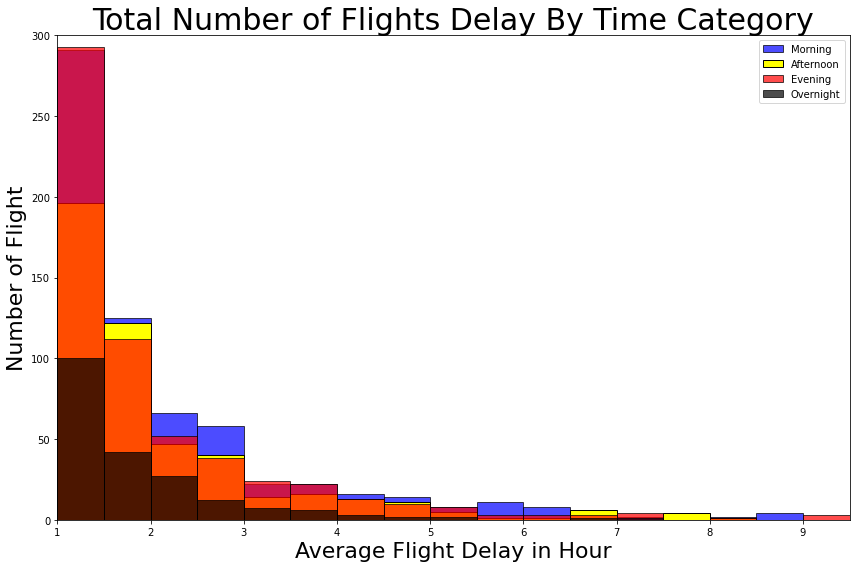

In [321]:
#What time flight are getting delay
plt.rcParams['figure.figsize'] = [12,8]
ax = plt.subplot()
ax.hist(flightmerge[flightmerge['Time Category'] == 'Morning']['Hour_Delay'], color = 'blue', alpha = 0.7,edgecolor = 'black',bins = bin, label = 'Morning')
ax.hist(flightmerge[flightmerge['Time Category'] == 'Afternoon']['Hour_Delay'], color = 'yellow', alpha = 1,edgecolor = 'black',bins = bin, label = 'Afternoon')
ax.hist(flightmerge[flightmerge['Time Category'] == 'Evening']['Hour_Delay'], color = 'red', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Evening')
ax.hist(flightmerge[flightmerge['Time Category'] == 'Overnight']['Hour_Delay'], color = 'black', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Overnight')
# Title and labels
ax.set_title('Total Number of Flights Delay By Time Category', size = 30)
ax.set_xlabel('Average Flight Delay in Hour', size = 22)
ax.set_ylabel('Number of Flight', size= 22)
plt.legend(loc='upper right')
plt.xlim(1,9.5)
plt.ylim(0,300)
plt.tight_layout()
plt.show()

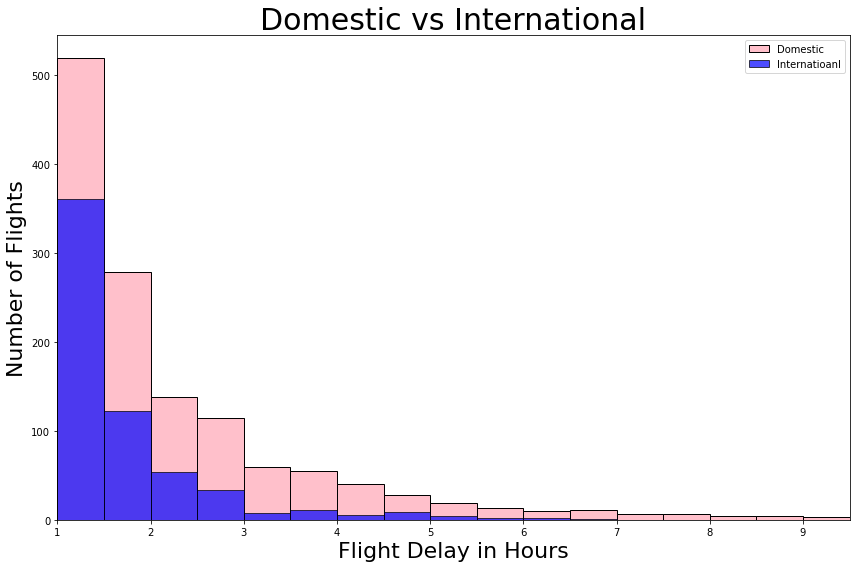

In [322]:
#Domestic vs International
plt.rcParams['figure.figsize'] = [12,8]
ax = plt.subplot()
ax.hist(flightmerge[flightmerge['International_Domestic'] == 'Domestic']['Hour_Delay'], color = 'pink', edgecolor = 'black',bins = bin,label = 'Domestic')
ax.hist(flightmerge[flightmerge['International_Domestic'] == 'International']['Hour_Delay'], color = 'blue', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Internatioanl')
# Title and labels
ax.set_title('Domestic vs International', size = 30)
ax.set_xlabel('Flight Delay in Hours', size = 22)
ax.set_ylabel('Number of Flights', size= 22)
plt.legend(loc='upper right')
plt.xlim(1,9.5)
#plt.ylim(0,30)
plt.tight_layout()
plt.show()

International Analysis

In [323]:
International = flightmerge[flightmerge.International_Domestic=='International']

In [324]:
International.head(3)

,Date,Flight_Schedule,Flight_Departure,International_Domestic,Non-PA_Airport_Country_Desc,Operating_Airline_Desc,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Hour_Delay,Time Category
1116,10/1/2021,2021-10-01 07:17:00,2021-10-01 08:22:09,International,Mexico,JetBlue Airways,Clear skies,0.0,10.0,1.085833,Morning
1150,10/1/2021,2021-10-01 20:50:00,2021-10-01 22:23:53,International,Portugal,TAP Portugal,Partly cloudy,0.0,10.0,1.564722,Evening
1192,10/10/2021,2021-10-10 05:01:00,2021-10-10 06:10:59,International,Dominican Republic,JetBlue Airways,Raining,0.0,8.0,1.166389,Overnight


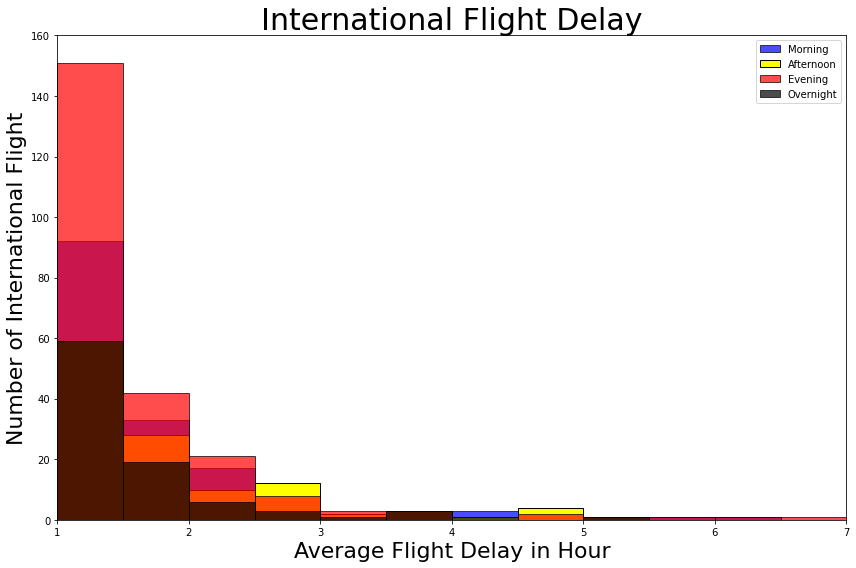

In [326]:
#What time flight are getting delay for International Flight
plt.rcParams['figure.figsize'] = [12,8]
ax = plt.subplot()
ax.hist(International[International['Time Category'] == 'Morning']['Hour_Delay'], color = 'blue', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Morning')
ax.hist(International[International['Time Category'] == 'Afternoon']['Hour_Delay'], color = 'yellow', alpha = 1,edgecolor = 'black',bins = bin,label = 'Afternoon')
ax.hist(International[International['Time Category'] == 'Evening']['Hour_Delay'], color = 'red', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Evening')
ax.hist(International[International['Time Category'] == 'Overnight']['Hour_Delay'], color = 'black', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Overnight')
# Title and labels
ax.set_title('International Flight Delay', size = 30)
ax.set_xlabel('Average Flight Delay in Hour', size = 22)
ax.set_ylabel('Number of International Flight', size= 22)
plt.legend(loc='upper right')
plt.xlim(1,7)
plt.ylim(0,160)
plt.tight_layout()
plt.show()

Domestic Analysis

In [308]:
Domestic = flightmerge[flightmerge.International_Domestic=='Domestic']

In [309]:
Domestic.head(3)

,Date,Flight_Schedule,Flight_Departure,International_Domestic,Non-PA_Airport_Country_Desc,Operating_Airline_Desc,Weather_Description,Precipitation_(Inches),Visibility_(Miles),Hour_Delay,Time Category
1113,10/1/2021,2021-10-01 21:29:00,2021-10-01 23:08:44,Domestic,USA,Frontier Airlines,Partly cloudy,0.0,10.0,1.662222,Evening
1120,10/1/2021,2021-10-01 05:20:00,2021-10-01 09:10:48,Domestic,USA,Spirit Airlines,Clear skies,0.0,10.0,3.846667,Overnight
1179,10/10/2021,2021-10-10 20:08:00,2021-10-10 21:12:28,Domestic,USA,Endeavor Airlines,Partly cloudy,0.0,10.0,1.074444,Evening


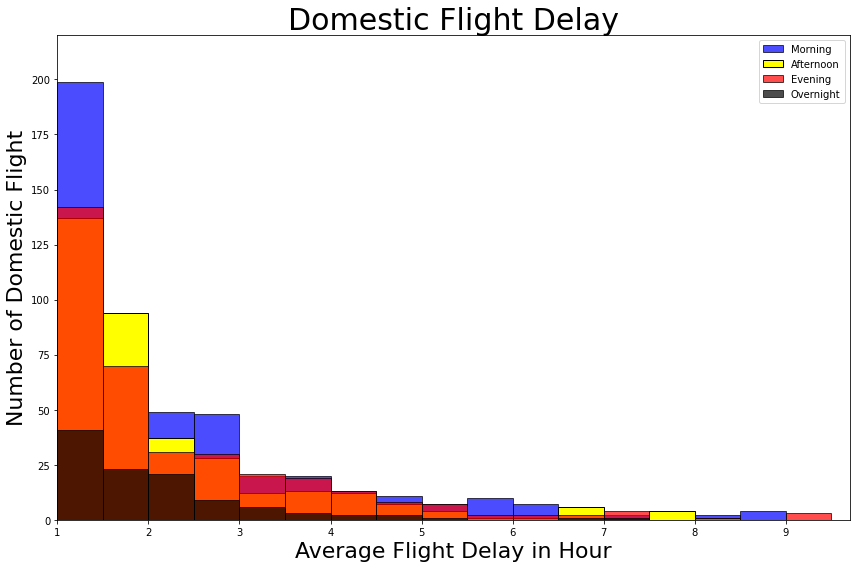

In [320]:
#What time flight are getting delay for Domestice Flight
plt.rcParams['figure.figsize'] = [12,8]
ax = plt.subplot()
ax.hist(Domestic[Domestic['Time Category'] == 'Morning']['Hour_Delay'], color = 'blue', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Morning')
ax.hist(Domestic[Domestic['Time Category'] == 'Afternoon']['Hour_Delay'], color = 'yellow', alpha = 1,edgecolor = 'black',bins = bin,label = 'Afternoon')
ax.hist(Domestic[Domestic['Time Category'] == 'Evening']['Hour_Delay'], color = 'red', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Evening')
ax.hist(Domestic[Domestic['Time Category'] == 'Overnight']['Hour_Delay'], color = 'black', alpha = 0.7,edgecolor = 'black',bins = bin,label = 'Overnight')
# Title and labels
ax.set_title('Domestic Flight Delay', size = 30)
ax.set_xlabel('Average Flight Delay in Hour', size = 22)
ax.set_ylabel('Number of Domestic Flight', size= 22)
plt.legend(loc='upper right')
plt.xlim(1,9.7)
plt.ylim(0,220)
plt.tight_layout()
plt.show()

Finding Max delay for both international and Domestic

In [213]:
flightmerge = flightmerge.rename(columns={"International_Domestic": "Destination", "Operating_Airline_Desc": "Airline","Time Category":"Time Of Day" })

In [214]:
col1 = 'Airline'
col2 = 'Destination'
col3 = 'Time Of Day'

In [215]:
#statistical values
df_stat = flightmerge.groupby([col1, col2, col3]).agg({'Hour_Delay':'count'})

In [216]:
df_max = flightmerge.groupby([col1,col2,col3])['Hour_Delay'].max()

In [217]:
df_stat['Max Hour Delay'] = df_max.values

In [218]:
df_median = flightmerge.groupby([col1,col2,col3])['Hour_Delay'].median()

In [219]:
df_stat['Median Delay'] = df_median.values

In [220]:
df_std = flightmerge.groupby([col1,col2,col3])['Hour_Delay'].std()

In [221]:
df_stat['Standard Deviation'] = df_std.values

In [222]:
df_stat.columns

Index(['Hour_Delay', 'Max Hour Delay', 'Median Delay', 'Standard Deviation'], dtype='object')

In [223]:
df_stat = df_stat.rename(columns={"Hour_Delay": "Total Hour Delay", })

In [224]:
df_stat.sort_values(by=['Total Hour Delay'],ascending=False).head(10)

Total Hour Delay  Max Hour Delay  \
Airline           Destination   Time Of Day                                     
Spirit Airlines   Domestic      Evening                    19        4.412778   
Frontier Airlines Domestic      Evening                    18       17.408889   
Spirit Airlines   Domestic      Afternoon                  11        4.668333   
                                Morning                    10        4.041389   
Porter Airlines   International Morning                     9        4.201667   
Frontier Airlines Domestic      Morning                     9        6.083611   
Delta Air Lines   Domestic      Morning                     8        8.786944   
Frontier Airlines Domestic      Afternoon                   8        6.660000   
Delta Air Lines   Domestic      Evening                     6        7.250000   
Lufthansa         International Evening                     4        2.623889   

                                             Median Delay  Standard Deviation  
Airline           Destination   Time Of Day                                    
Spirit Airlines   Domestic      Evening          1.636944            1.081459  
Frontier Airlines Domestic      Evening          1.490694            3.843204  
Spirit Airlines   Domestic      Afternoon        1.425000            1.275387  
                                Morning          1.463056            1.068507  
Porter Airlines   International Morning          1.226667            1.008280  
Frontier Airlines Domestic      Morning          1.250556            1.755623  
Delta Air Lines   Domestic      Morning          8.048056            3.204184  
Frontier Airlines Domestic      Afternoon        1.446250            2.040919  
Delta Air Lines   Domestic      Evening          1.389722            2.498827  
Lufthansa         International Evening          1.690833            0.666291

In [225]:
df_stat = pd.DataFrame(df_stat)

In [226]:
df_stat.to_csv('Flight_Schedule_AnalysisV3.csv')

In [227]:
df=pd.read_csv('Flight_Schedule_AnalysisV2.csv')

In [228]:
df.sort_values(by=['Total Hour Delay'],ascending=False).head(10).reset_index(drop=True)


,Airline,Destination,Time Of Day,Total Hour Delay,Max Hour Delay,Median Delay,Standard Deviation
0,Spirit Airlines,Domestic,Evening,19,4.412778,1.636944,1.081459
1,Frontier Airlines,Domestic,Evening,18,17.408889,1.490694,3.843204
2,Spirit Airlines,Domestic,Afternoon,11,4.668333,1.425000,1.275387
3,Spirit Airlines,Domestic,Morning,10,4.041389,1.463056,1.068507
4,Porter Airlines,International,Morning,9,4.201667,1.226667,1.008280
5,Frontier Airlines,Domestic,Morning,9,6.083611,1.250556,1.755623
6,Delta Air Lines,Domestic,Morning,8,8.786944,8.048056,3.204184
7,Frontier Airlines,Domestic,Afternoon,8,6.660000,1.446250,2.040919
8,Delta Air Lines,Domestic,Evening,6,7.250000,1.389722,2.498827
9,Lufthansa,International,Evening,4,2.623889,1.690833,0.666291


DOMESTIC ANALYSIS

In [ ]:
df_domes = df[df.Destination=='Domestic']

In [ ]:
df_domes.sort_values(by=['Total Hour Delay'],ascending=False).head(10).reset_index(drop=True)

In [ ]:
#Domestic flights

df_domes.describe()

INTERNATIONAL ANALYSIS

In [ ]:
df_inter = df[df.Destination=='International']

In [ ]:
df_inter.sort_values(by=['Total Hour Delay'],ascending=False).head(10).reset_index(drop=True)

In [ ]:
df_inter.columns

In [ ]:
df_inter1= df_inter[['Airline', 'Destination', 'Time Of Day', 'Total Hour Delay', 'Median Delay', 'Standard Deviation']].groupby(['Airline']).sum()

In [ ]:
df_inter1.describe()

In [ ]:
df_inter1 = df_inter1.sort_values(by=['Total Hour Delay'],ascending=False).head(10).reset_index(drop=True)

In [ ]:
#Internation flight analysis
df_inter1